In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import torch
import glob
import pickle
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image

In [2]:
import sys
sys.path.append("../pyfiles/")
from util import *
from dataset import Dataset_mel
from model import Generator_mel, Discriminator_mel
from WaveGlow import call_waveglow, audio_generation

---

<font size="5">Overviews</font>
1. Introduction
1. Audio Dataset in Mel-spectrogram
1. Preparation of GAN's training
1. Training
1. Results

---

# Introduction
---
In this notebook, I'm going to explain how to train your GAN model.
GAN's going to generate the audio data in a form of mel-spectrogram. 
I mean it'll output 2-dimensional data. 
Therefore, before conducting the experiment, you need to visit `A_preprocessing_TESS_and_RAVDESS.ipynb` to conduct some preprocessing techniques, including to syncopate the silence section and to convert it into mel-spectrogram.

I won't explain all the functions or models in this notebook, so, please visit `pyfiles/` for further and detailed information.

---

# Dataset
---
I won't explain the detail of the dataset and the preprocessing, please visit `A_preprocessing_TESS_and_RAVDESS.ipynb` for detailed information.

---

## Preparation
---
At first, I defined some valuables for dataset.

---

In [4]:
# ----- adjustable parameters ----- #
emotions = ["neutral", "happy", "sad", "angry"] # the labels of classes
classes = tuple(range(len(emotions))) # classes tuple
target_length = 2**15 # data length, about 1.5 seconds
fs = 22050 # samling rate
root_TESS = "../../dataset/TESS/preprocessed/" # root path of the TESS dataset
root_RAVDESS = "../../dataset/RAVDESS/preprocessed/" # root path of the RAVDESS dataset
# --------------------------------- #

---
Since data have different lengths, the data is randomly cropped to avoid over-fitting or fix the length. 

---

In [5]:
dataset = Dataset_mel(root_TESS, root_RAVDESS, transform_mel, emotions, target_length, mode="all", dataset="both")
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

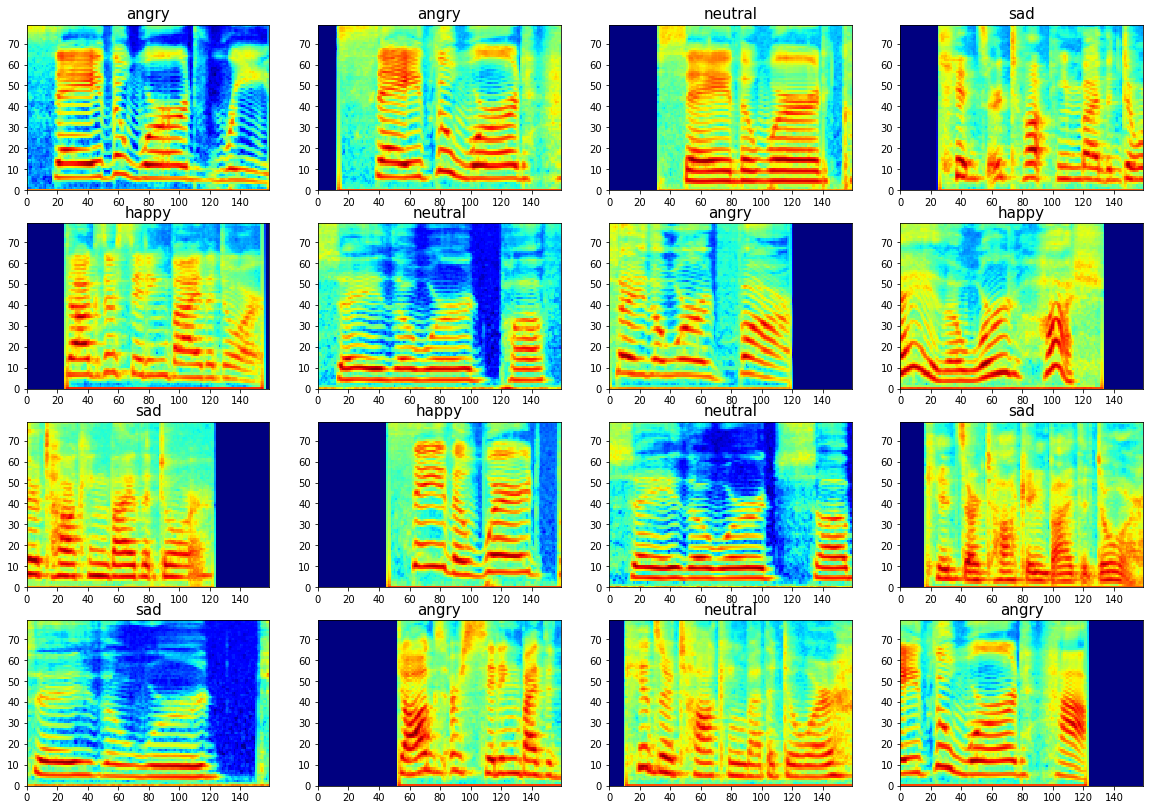

In [6]:
display_num = 16
fig = plt.figure(figsize=(20, 14))
for i in range(display_num):
    data = dataset[np.random.randint(0, len(dataset))]
    M = data[0].numpy()[0]
    plot_spectrogram(M, fig, (4,4,i+1), title=emotions[data[1]])

# Preparation of GAN's training
---
Ok, let's take a look at the training condition.
For the sake of stability and semantic generation, [consistency regularization](https://openreview.net/forum?id=S1lxKlSKPH) 
and [Unrolled GAN](https://arxiv.org/abs/1611.02163) are employed, respectively, please check the link.

---

Well, next, some hyperparameters for training are defined below.
If you would like to add more algorithms for GAN training, 
you can allocate the coefficient in a form of 'lbd' below.

---

In [7]:
# ----- adjustable parameters ----- #
epoch_num = 301
ndim = 512 # size of the noise vector, related to the capacity of the model.
lr_D = 0.001
lr_G = 0.001
unrolled_k = 5 # 'k' for unrolled GAN
save_parameter = True # do you wanna save parameters ?
device = "cuda" if torch.cuda.is_available() else "cpu"
device
# --------------------------------- #

'cuda'

In [8]:
# ----- adjustable parameters ----- #
lbd = {}
lbd["consisreg"] = 0.1 # lambda for Consistency Regularization
# --------------------------------- #

---
For the sake of tidy implementation, I'm gonna define a function which conducts the training process, which is named 'GAN_training'. it'll include some training initialization algorithms such as an optimizer and a learning-rate scheduler, as well as the training process. The training will be initiated by executing the 'train' and inserting real images and concomitant labels. In this experiment, I'll employ the following algorithms:
- optimizer: Adam optimizer with beta1 as 0.5 and beta2 as 0.999
- scheduler: learning rate scheduler which lowers the lr exponentially

---

In [9]:
class GAN_training():
    def __init__(self, net, criterion, unrolled_k, classes, device, lbd):
        self.G, self.D = net[0].to(device), net[1].to(device)
        self.optG, self.optD = None, None
        self.scheG, self.scheD = None, None
        self.criterion = criterion
        self.k = unrolled_k
        self.classes = classes
        self.device = device
        self.lbd = lbd
        self.real_image = None
        self.real_image_label = None
        self.fake_noise_label = None
        self.fake_label = None
        
    
    def opt_sche_initialization(self, lr=[0.001, 0.001]):
        lr_G, lr_D = lr
        self.optG = optim.Adam(self.G.parameters(), lr=lr_G, betas=(0.5, 0.999))
        self.scheG = optim.lr_scheduler.ExponentialLR(self.optG, gamma=0.99)
        self.optD = optim.Adam(self.D.parameters(), lr=lr_D, betas=(0.5, 0.999))
        self.scheD = optim.lr_scheduler.ExponentialLR(self.optD, gamma=0.99)
        return
    
    def get_loss_D(self, output, target=1.):
        loss = 0.0
        targets = torch.full((output.shape), target, device=self.device)
        loss += criterion(output, targets)
        return loss
    
    def update_D(self):
        self.D.zero_grad()
        
        
        errD = 0
        # Conventional Loss
        
        real_feature = self.D(self.real_image)
        output = F.sigmoid(real_feature)
        errD_real = self.get_loss_D(output, 1.)
        errD += errD_real

        fake_image = self.G(self.fake_noise)
        output = self.D(fake_image.detach())
        output = F.sigmoid(output)
        errD_fake = self.get_loss_D(output, 0.)
        errD += errD_fake
        
        # Consistency Regularization
        if self.lbd["consisreg"] > 0:
            augmented = get_augmented_image(self.real_image, augment, mean0=False).to(device)
            augmented_feature = self.D(augmented)
            errD_consisreg = torch.mean(torch.abs(augmented_feature - real_feature)*2)
            errD += errD_consisreg*self.lbd["consisreg"]
        
        errD.backward()
        self.optD.step()
        
        return errD
    
    def update_G(self):
        self.G.zero_grad()

        fake_image = self.G(self.fake_noise)
        
        output = self.D(fake_image)
        output = F.sigmoid(output)
        errG = self.get_loss_D(output, 1.)
        
        errG.backward()
        self.optG.step()
        
        return errG
    
    def UnrolledUpdate(self):
        for i in range(self.k):

            # update D
            errD = self.update_D()
            if i==0:
                paramD = self.D.state_dict()
                errorD = errD

        # update G
        errorG = self.update_G()
        self.D.load_state_dict(paramD)
        
        return [errorG, errorD]
        
        
    def train(self, real_image):
        self.real_image = real_image
        
        noise = torch.randn(real_image.shape[0], ndim, 1, 1, device=self.device)
        self.fake_noise = noise
        
        error = self.UnrolledUpdate()
        
        return error

---
Let's call GAN models and the algorithm.
As you can see below, loss function will be Mean Square Error Loss (MSELoss)

---

In [10]:
netG = Generator_mel(ndim=ndim, nch_output=1)
netG = netG.to(device)
netG.apply(weights_init)
netD = Discriminator_mel(nch_input=1, nch_output=1)
netD = netD.to(device)
netD.apply(weights_init)
criterion = nn.MSELoss()
gan = GAN_training([netG, netD], criterion, unrolled_k, classes, device, lbd)
gan.opt_sche_initialization(lr=[lr_G, lr_D])

## train

---
dataset preparation

---

In [11]:
dataset = Dataset_mel(root_TESS, root_RAVDESS, transform_mel, emotions, target_length, mode="all", dataset="both")
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=128, shuffle=True)
len(dataset)

2464

---
To observe the transition of the results, you should fix the noise a generator's gonna eat.

---

In [12]:
fixed_noise = torch.randn(4, ndim, 1, 1, device=device).to(device)

# Training
---
Let's train your model.
The notebook gives you the losses and the generation of every epoch.

---

301


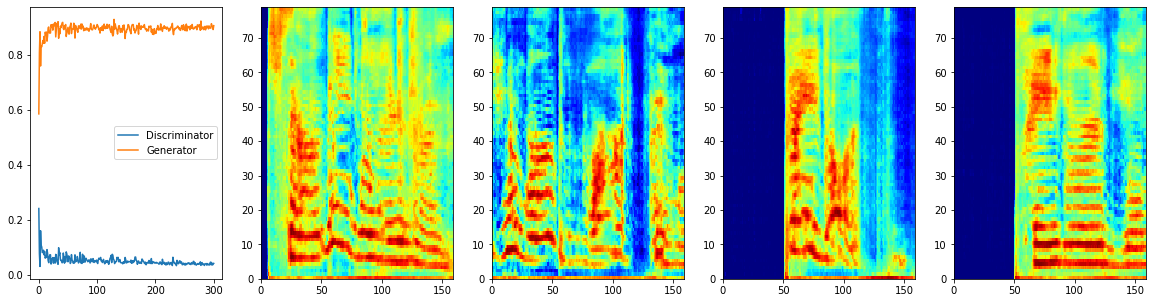

In [20]:
losses_epoch_D = []
losses_epoch_G = []
for epoch in range(epoch_num):
    losses_G = []
    losses_D = []
    for itr, data in enumerate(dataloader):
        real_image = data[0].to(device)
        real_label = data[1].to(device)
        
        errG, errD = gan.train(real_image)
        
        losses_G.append(cuda_to_numpy(errG))
        losses_D.append(cuda_to_numpy(errD))
        
    if save_parameter:
        if epoch % 10 == 0:
            torch.save(netG.state_dict(), 
                       f"./instant_model_parameter/gen_celebA_unrolled{unrolled_k}_ndim{ndim}_lbd_consisreg{lbd['consisreg']}_epoch{epoch}.pth")
            torch.save(netD.state_dict(), 
                       f"./instant_model_parameter/dis_celebA_unrolled{unrolled_k}_ndim{ndim}_lbd_consisreg{lbd['consisreg']}_epoch{epoch}.pth")
        
    losses_epoch_G.append(np.mean(np.array(losses_G)))
    losses_epoch_D.append(np.mean(np.array(losses_D)))
    
    gan.scheG.step()
    gan.scheD.step()
    
    sample_image = cuda_to_numpy(netG(fixed_noise))
    clear_output(wait=True)
    print(epoch+1)
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(1,5,1)
    ax.plot(losses_epoch_D, label="Discriminator")
    ax.plot(losses_epoch_G, label="Generator")
    ax.legend()
    for i in range(4):
        M = sample_image[i][0]
        plot_spectrogram(M, fig, (1,5,2+i))
    plt.show()

# Results
---
Let's observe the results of the model we've trained.

First of all, since it was a lengthy process and some of you might not be able to train quickly, I've finished the process and saved the parameters in `data/parameters/`. So, let's call it with the code below.

---

## Mel-spectrogram generation
---
Ok, well, let's take a look at the mel-spectrogram generation. 

---

In [15]:
lbd = {}
lbd["consisreg"] = 0.1
ndim = 512
load_epoch = 300
unrolled_k = 5
gen_path = f"../data/parameters/gen_celebA_unrolled{unrolled_k}_ndim{ndim}_lbd_consisreg{lbd['consisreg']}_epoch{load_epoch}.pth"
gen_model = torch.load(gen_path)
netG.load_state_dict(gen_model)

<All keys matched successfully>

In [16]:
generate_num = 16

# noise generation
fake_noise = torch.randn(generate_num,ndim,1,1).to(device)

# mel-spectrogram generation
netG.eval()
new_image = netG(fake_noise).detach().to("cpu").numpy()

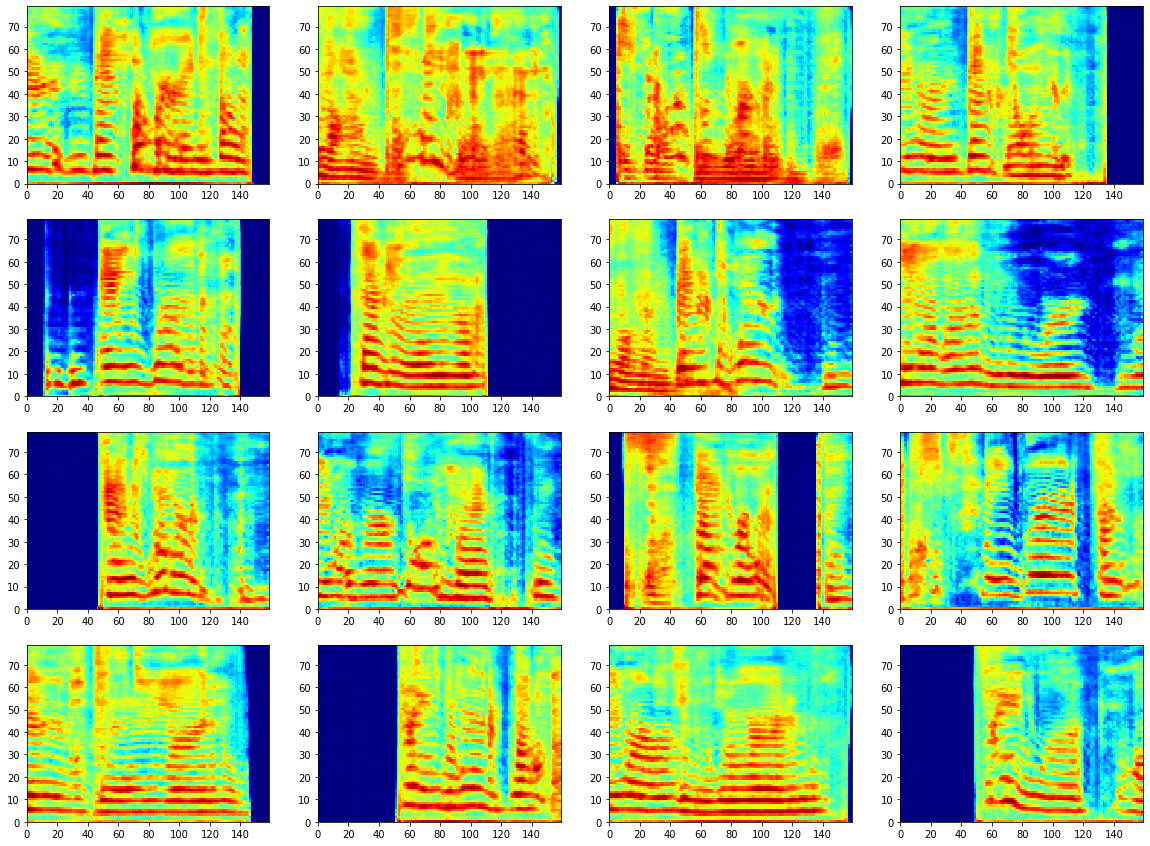

In [17]:
fig = plt.figure(figsize=(20, 15), facecolor="w")
ax = []
for i in range(generate_num):
    M = new_image[i][0]
    plot_spectrogram(M, fig, (4,4,i+1))

## Audio generation via WaveGlow
---
Next, this is a little bit tricky. We're going to hear the audio which is converted from the generated mel-spectrogram using pre-trained WaveGlow. The audio converting model is trained with [LJSpeech](https://keithito.com/LJ-Speech-Dataset/) in advance and it's available in PyTorch official implementation. I've slightly modified it for my own use and it's detailed in `B_WaveGlow_parameters.ipynb`. By using this model, the generated mel-spectrogram is converted into audio data. Ok, so please see the code below. You can call the WaveGlow model.

---

In [18]:
model_path = "../data/parameters/waveglow_official.pth"
waveglow = call_waveglow(model_path, True, device)

---
We need to rescale the mel-spectrograms prior to conversion.

---

In [19]:
for i in range(generate_num):
    new_image[i] = mel_normalize(new_image[i], "LJSpeech")

---
Conversion and Visualization

---

In [20]:
audio_list = []
for i in range(generate_num):
    image = torch.Tensor(new_image[i]).to(device)
    audio, _ = audio_generation(image, waveglow)
    audio_list.append(audio)

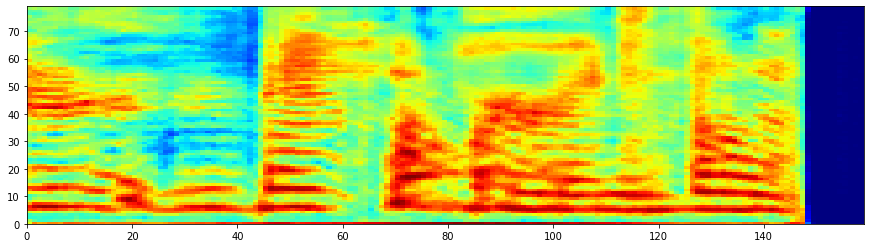

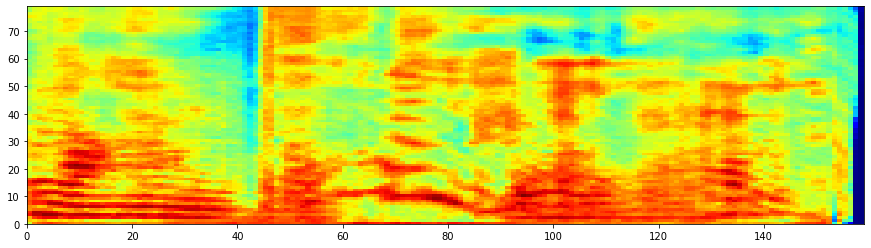

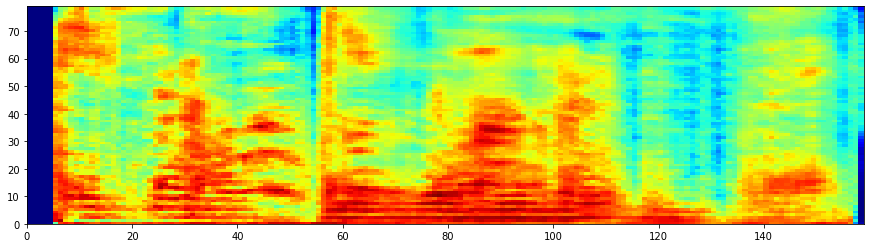

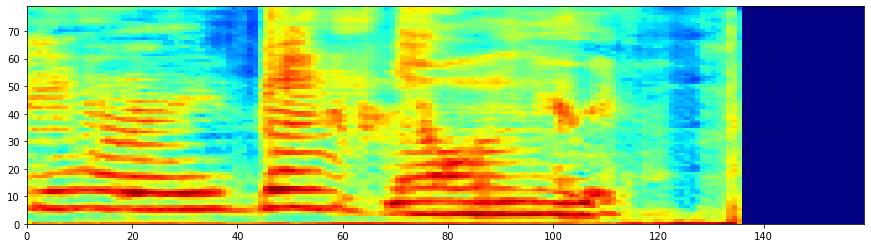

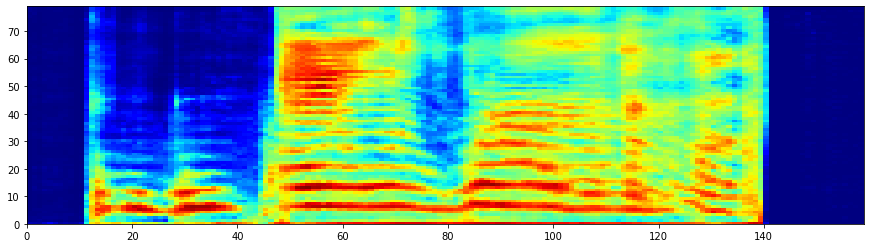

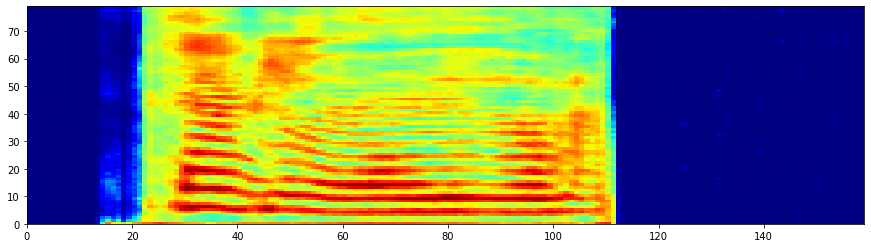

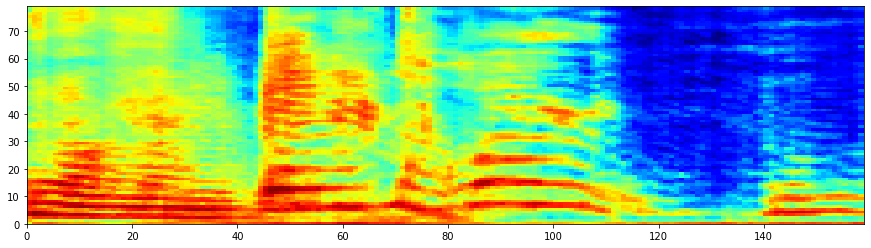

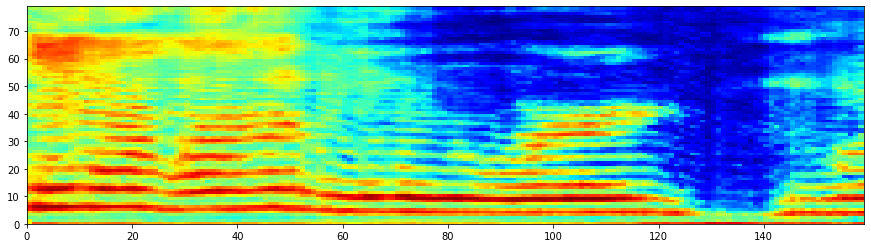

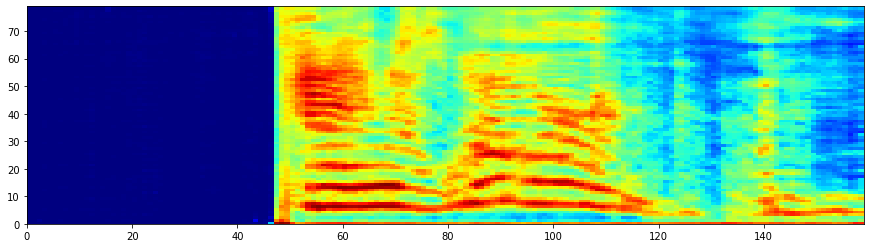

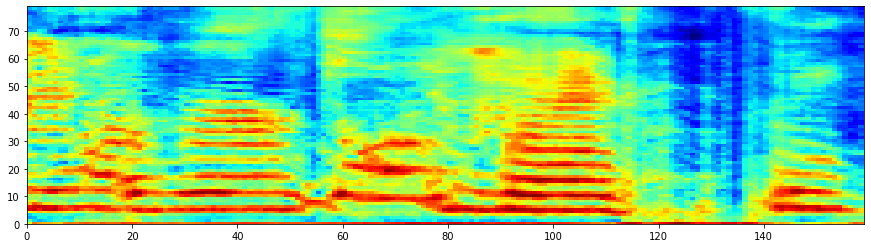

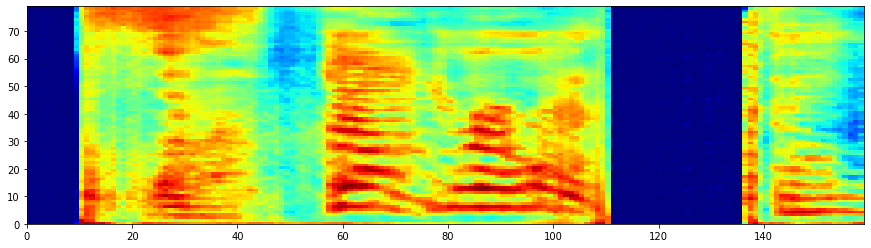

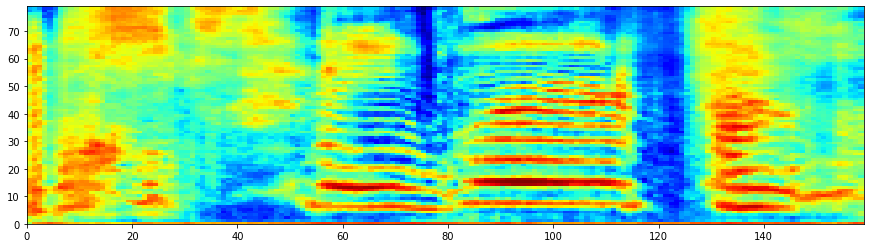

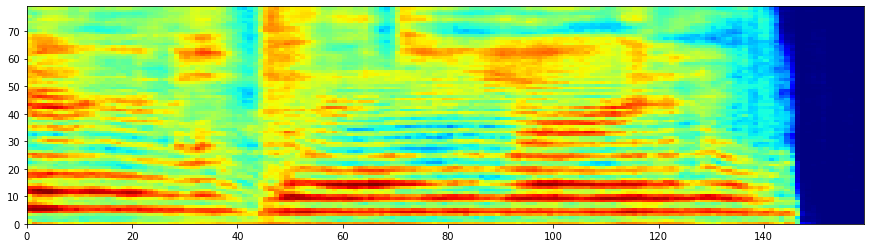

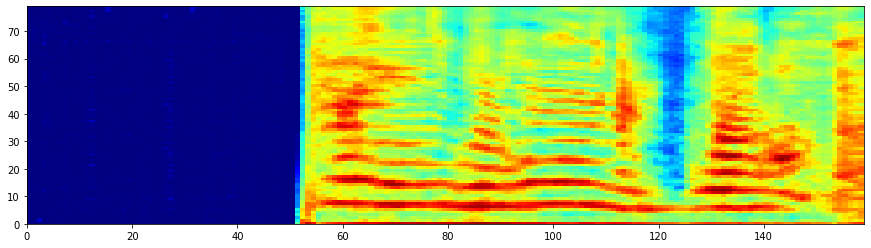

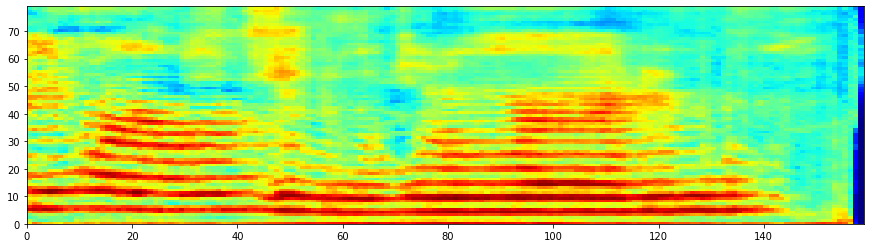

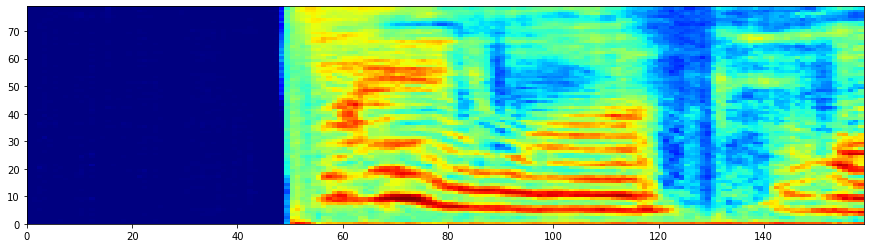

In [21]:
for i in range(generate_num):
    fig = plt.figure(figsize=(15, 4), facecolor="w")
    M = new_image[i][0]
    plot_spectrogram(M, fig, (1,1,1))
    plt.show()
    play_audio(audio_list[i], 22050)

---
It seems the statements are too elusive but we can narrowly recognize the voice.

---